In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

import os
import pickle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPool1D, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Reshape, UpSampling1D

from tensorflow.keras.models import Model

import tensorflow as tf

**TIP**: to reset initial weight to random, define mdoel in a function and use .get_model() !!

In [2]:
data_dict =  load_split_pool(1346, 430, 10, scale = True, normalize_by_sflux = True)

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


In [3]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters', 'wavelengths'])

In [4]:
data_dict["x_pooled"]["train"].min().min()

-2.585272695311749

# Train-val data as tensors

In [4]:
x_train = data_dict["x_pooled"]["train"]
x_val = data_dict["x_pooled"]["val"]

x_train = tf.expand_dims(x_train, 1)
x_val = tf.expand_dims(x_val, 1)

In [5]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))

# Process the datasets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))


train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

# Autoencoder functions

In [9]:

encoded_dim = 50

def get_simple_autoencoder(encoded_dim):
    '''
    Get 4-layer auroencoder Model instance, with bottlencek of size "encoded_dim"
    '''

    encoder = Sequential([
        Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
    ])
    print(encoder.summary())
    
    decoder = Sequential([
        Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(11001, activity_regularizer=regularizers.l1(0)),
    ])
    
    print(decoder.summary())
    
    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [10]:
def get_6layer_autoencoder(encoded_dim):
    '''
    Get 6-layer auroencoder Model instance, with bottlencek of size "encoded_dim"
    '''  
    
    reg_alpha = 0
    encoder = Sequential([
        Dense(128, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(64, activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(encoded_dim, activity_regularizer=regularizers.l2(reg_alpha) ),
    ])
    print(encoder.summary())

    decoder = Sequential([
        Dense(64, input_shape = (1, encoded_dim) , activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(128, activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(11001, activity_regularizer=regularizers.l2(reg_alpha)),
    ])

    print(decoder.summary())

    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [6]:
def rescale_back(observation, mean, std, flux):
    '''
    Reverse standardisation using the given parameters
    '''
    return( (observation*std + mean)*flux ) 


def get_loss_autoencoder(x_val, get_model_function, encoded_dim, epochs, verbose = 'auto', 
                         rescale = True, mean = None, std = None, flux = None):
    '''
    Calculate RMSE of autoencoder for a given bottleneck and number of epochs to train.
    Uses early stopping (to allow training many models with the same number of epochs)
    
    Inputs:
    - get_model_function: autoencoder Model instance
    - encoded_dim: bottleneck size
    - epochs: number of epochs used to train
    (train and al set loaded as global vars.)
    
    Outputs:
    - RMSE loss
    - plot of train and test loss vs epoch number

    '''
    
    autoencoder = get_model_function(encoded_dim)  
    
    autoencoder.reset_states()
    
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

    autoencoder.compile(loss = 'mean_squared_error', optimizer="Adam") # since output is zero or 1 use binary loss
    # default optimiser: RMS propr
    autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                    verbose = verbose, callbacks = earlystopping)
    
    fig, ax = plt.subplots()
    ax.plot(autoenc_history.history["loss"], label = "loss")
    ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
    ax.legend()
    
    print(fig)
    
    x_predicted_val = autoencoder.predict(test_dataset)
    print("Prediction shape", x_predicted_val.shape)

    if rescale == True:
        x_val = rescale_back(x_val, mean, std, flux)
        x_predicted_val = rescale_back( x_predicted_val, mean, std, flux )


    autoenc_loss = ((x_predicted_val.ravel() - x_val.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
    print("Loss:", autoenc_loss)
    
    return(autoenc_loss, fig)

# Finding the best bottleneck size for both 4 and 6 layer autoencoders

In [11]:
# Fit and evaluate 4 layer autoencoder for different sizes of bottleneck

autoenc_simple_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(x_val, get_simple_autoencoder, latent_space_size, 100, verbose = '0', 
                                     rescale = True, mean = data_dict["parameters"]["mean"], std = data_dict["parameters"]["std"],
                                    flux = data_dict["x_pooled"]["val_df_pooled_total_flux"])
    fig
    
    autoenc_simple_loss.append( loss )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 264)            1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              265       
Total params: 2,905,849
Trainable params: 2,905,321
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 264)            528       
_____________________________________________________________

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\jbryb\gsof_env\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-a54386389d2a>", line 12, in <module>
    loss, fig = get_loss_autoencoder(x_val, get_simple_autoencoder, latent_space_size, 100, verbose = '0',
  File "<ipython-input-10-0f4e481cb7e0>", line 34, in get_loss_autoencoder
    autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
  File "C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 950, in _call
    return self._stateless_fn(*arg

TypeError: object of type 'NoneType' has no len()

In [18]:
# Pickle the results

# put results into a dictionary
autoenc_simple_loss_dict = dict()
autoenc_simple_loss_dict["loss"] = autoenc_simple_loss
autoenc_simple_loss_dict["dim"] = latent_space_size_list



In [19]:
# pickle
dump_object("simple_autoencoder_loss_finegrid_wflux", autoenc_simple_loss_dict)

()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_48 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_97 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_49 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_98 (Dense)             (None, 1, 1)              65        
Total params: 1,417,345
Trainable params: 1,416,961
Non-trainable params: 384
_________________________________________________________________
None
Model: "sequen

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0019705317861591354
Latent space size 5
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_64 (Batc (None, 1, 128)            512       
_____________

Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016862073551870956
Latent space size 8
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_76 (Batc (None, 1, 128)            512       
______________________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0017087502408107628
Latent space size 11
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_88 (Batc (None, 1, 128)            512       
____________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016738891045260892
Latent space size 14
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_100 (Bat (None, 1, 128)            512       

Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016919482522810595
Latent space size 17
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_112 (Bat (None, 1, 128)            512       
_________________________________________________________________
dense_193 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_113 (B

Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016513053471943627


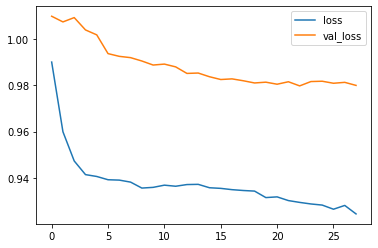

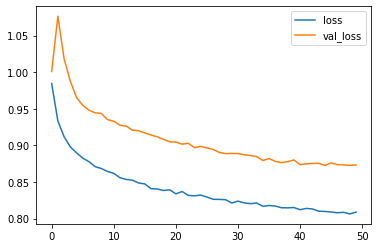

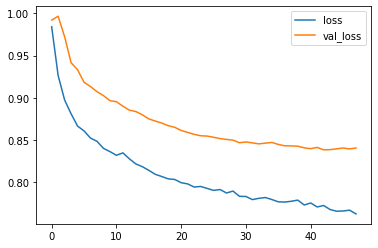

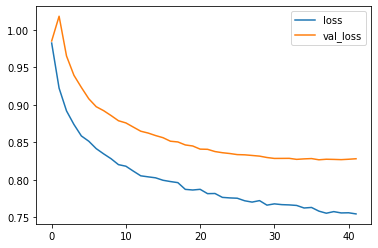

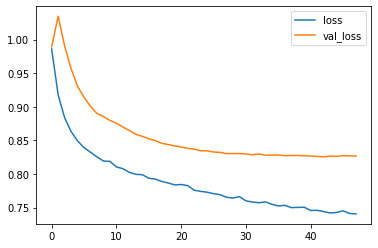

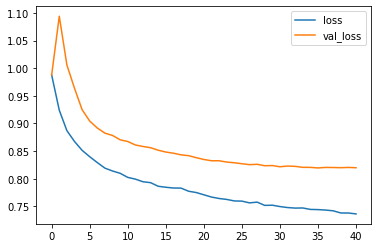

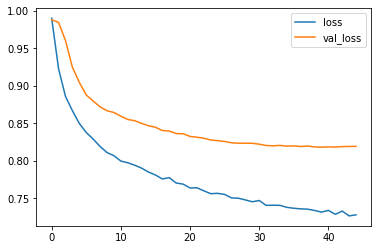

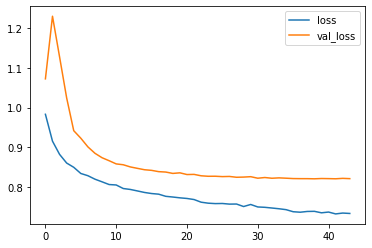

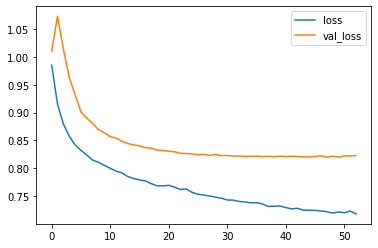

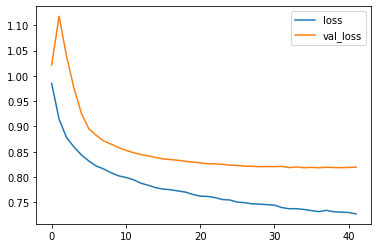

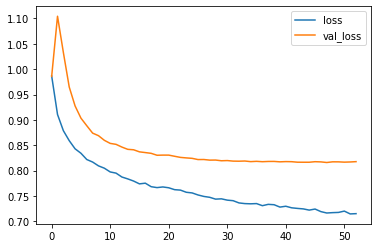

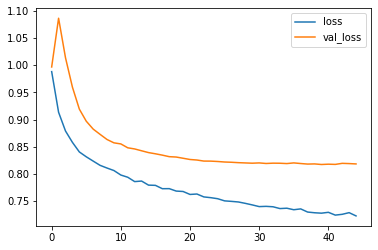

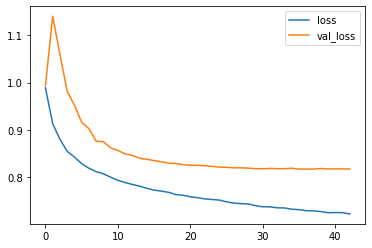

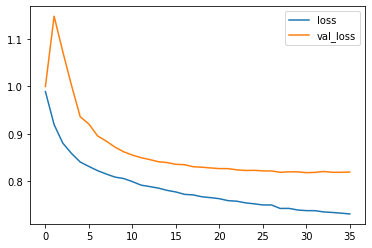

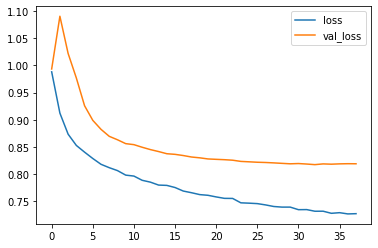

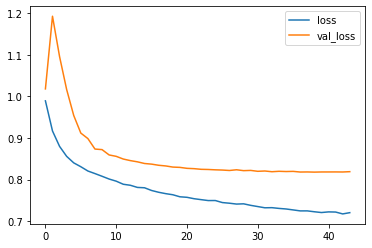

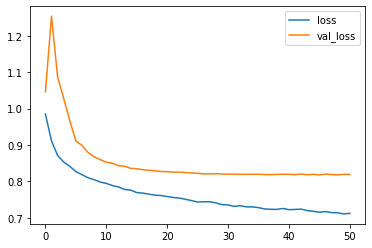

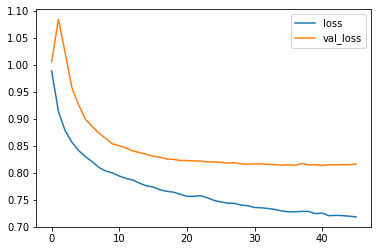

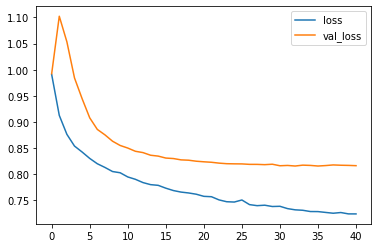

In [20]:
# Fit and evaluate 6 layer autoencoder for different sizes of bottleneck

autoenc_6layer_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(x_val, get_6layer_autoencoder, latent_space_size, 100, verbose = '0',
                                    rescale = True, mean = data_dict["parameters"]["mean"], std = data_dict["parameters"]["std"],
                                    flux = data_dict["x_pooled"]["val_df_pooled_total_flux"])
    fig
    
    autoenc_6layer_loss.append( loss )

In [21]:
# Pickle the results for 6 layer autoencoder

# put results into a dictionary
autoenc_6layer_loss_dict = dict()
autoenc_6layer_loss_dict["loss"] = autoenc_6layer_loss
autoenc_6layer_loss_dict["dim"] = latent_space_size_list


In [22]:

# pickle
dump_object("6layer_autoencoder_loss_finegrid_wflux", autoenc_6layer_loss_dict)

()

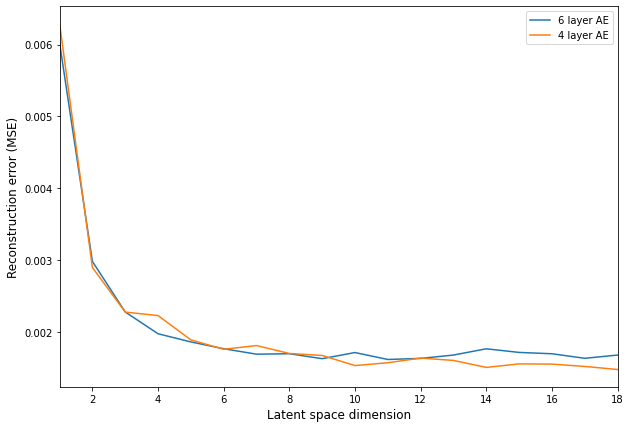

In [23]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(autoenc_6layer_loss_dict["dim"], autoenc_6layer_loss_dict["loss"], label = "6 layer AE")
ax.plot(autoenc_simple_loss_dict["dim"], autoenc_simple_loss_dict["loss"], label = "4 layer AE" )
ax.set_xlabel("Latent space dimension", fontsize = 12)
ax.set_ylabel("Reconstruction error (MSE)", fontsize = 12)
ax.set(xlim = (1,18) )
ax.legend();

# Final autoencoder

In [8]:
# def rescale_back(observation, mean, std):
#     return( observation*std + mean ) 

In [7]:
encoded_dim = 5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 264)            1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 5)              1325      
Total params: 2,906,909
Trainable params: 2,906,381
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 264)            1584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 264)            1056      
_________________

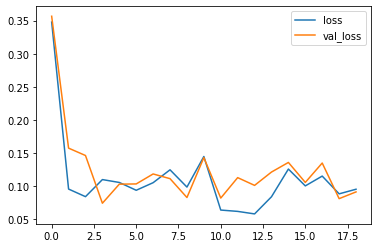

In [8]:
# Pick one model to train:

# autoencoder = get_simple_autoencoder(encoded_dim) 

encoder = Sequential([
    Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
])
print(encoder.summary())

decoder = Sequential([
    Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(11001, activity_regularizer=regularizers.l1(0)),
])

print(decoder.summary())

autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
autoencoder.reset_states()

epochs = 30
verbose = 'auto'

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)

autoencoder.compile(loss = 'mean_absolute_error', optimizer="Adam") # since output is zero or 1 use binary loss
# default optimiser: RMS propr
autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                verbose = verbose, callbacks = earlystopping)

fig, ax = plt.subplots()
ax.plot(autoenc_history.history["loss"], label = "loss")
ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
ax.legend()

print(fig)

x_predicted_val = autoencoder.predict(test_dataset)

# def rescale_back(observation, mean, std):
#     '''
#     Reverse standardisation using the given parameters
#     '''
#     return( observation*std + mean ) 


mean = data_dict["parameters"]["mean"]
std =  data_dict["parameters"]["std"]
# x_val_rescaled = rescale_back(x_val, mean, std)
# x_predicted_val_rescaled = rescale_back( x_predicted_val, mean, std )

print("Prediction shape", x_predicted_val.shape)

# autoenc_loss = ((x_predicted_val_rescaled.ravel() - x_val_rescaled.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
# print("Loss:", autoenc_loss)

In [54]:
mean

nan

In [9]:
x_projected_autoenc_tensor = encoder(x_val)
x_projected_autoenc = x_projected_autoenc_tensor.numpy()[:, 0, :]

In [10]:
x_predicted_val = autoencoder.predict(test_dataset)[:, 0, :]
x_predicted_val_rescaled = rescale_back( x_predicted_val, mean, std, flux = data_dict['x_pooled']["val_df_pooled_total_flux"] )

# x_reconstructed_autoenc = x_predicted_val.numpy()[:, 0, :]

In [11]:
x_val_rescaled = rescale_back( x_val[:, 0,:].numpy(), mean, std, flux = data_dict['x_pooled']["val_df_pooled_total_flux"] ) 
# x_val_rescaled_flux = x_val_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"]
# x_predicted_val_rescaled_flux = x_predicted_val_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"]

In [17]:
# data_dict["x_pooled"]["val_df_pooled_total_flux"] - data_dict["x_pooled"]["val_df_pooled_total_flux"]

In [18]:
# x_val_rescaled_flux = x_val[:, 0,:].numpy() * data_dict["x_pooled"]["val_df_pooled_total_flux"]
# x_predicted_val_rescaled_flux = x_predicted_val * data_dict["x_pooled"]["val_df_pooled_total_flux"]

In [12]:
((x_predicted_val_rescaled - x_val_rescaled)**2).mean()

0.024108834971761153

In [34]:
x_predicted_val_rescaled[56, :]

array([1.02781236, 1.22836573, 1.23927726, ..., 1.0788873 , 0.93990194,
       0.32394772])

In [15]:
autoenc_4layer = dict()
autoenc_4layer["x_original_val"] = x_val
autoenc_4layer["x_projected_val"] = x_projected_autoenc
autoenc_4layer["x_reconstructed_val"] = x_predicted_val
autoenc_4layer["autoenc_history"] = autoenc_history.history # dictionary with all useful info 
# autoenc_history.save('outputs/simple_autoenc_history')

In [ ]:
# import os
# import pickle

# dump_object("simple_autoenc_object", autoenc_4layer)

Text(0, 0.5, 'Sum of absolute errors \n (log scale)')

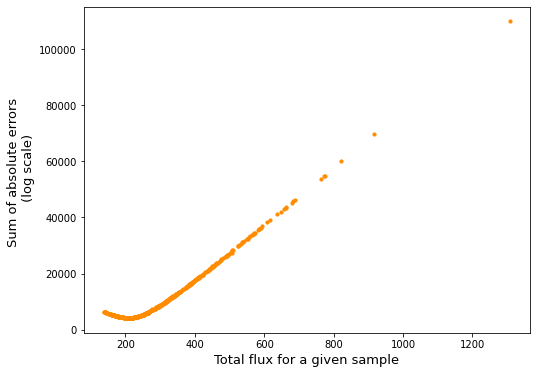

In [50]:
fix, ax = plt.subplots(figsize = (8, 6))
ax.scatter(data_dict['x_pooled']["val_df_pooled_total_flux"], np.abs(x_predicted_val_rescaled - x_val_rescaled).sum(axis = 1), s = 10, color = "darkorange")
ax.set_xlabel("Total flux for a given sample", fontsize = 13)
ax.set_ylabel("Sum of absolute errors \n (log scale)" , fontsize = 13)
# ax.set_yscale('log')
# ax.set_xscale('log')

In [51]:
pd.DataFrame(np.abs(x_predicted_val_rescaled - x_val_rescaled)).sum(axis = 1).sort_values()

158    151.429990
267    152.242158
124    152.462394
237    153.007574
194    153.879864
          ...    
417    450.162405
292    486.611812
84     535.696840
125    617.261709
56     764.965359
Length: 430, dtype: float64

In [47]:
pd.DataFrame(data_dict['x_pooled']["val_df_pooled_total_flux"]).sort_values(by = 0)

,0
232,138.366915
267,139.366646
124,139.777989
237,140.561602
293,140.629650
...,...
358,771.626712
292,775.331555
147,822.241888
125,916.341624


In [26]:
(( pd.DataFrame(data_dict["x"]["val"]) - 1 )**2).mean(axis = 1).sort_values()

359    0.002502
108    0.002503
317    0.002509
321    0.002518
24     0.002519
         ...   
167    0.048422
171    0.052416
46     0.055288
325    0.068773
248    0.080668
Length: 380, dtype: float64

## Signal recovery

In [35]:

random.seed(44223)
random_number_list = random.sample(range(x_val.shape[0]), 40, )

random_number_list = [349]

(11001,)


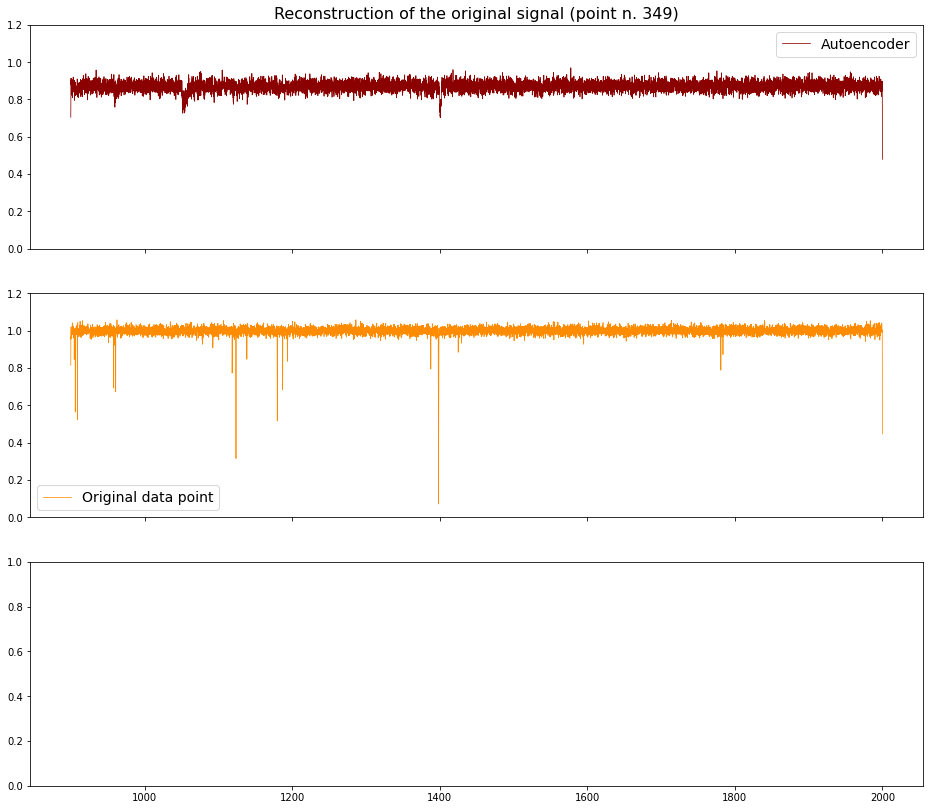

In [36]:
for random_number in random_number_list:
    x = tf.expand_dims(x_val[random_number, :], 1)
    x_projected = autoencoder.predict(x)
    x_projected_rescaled = x_predicted_val_rescaled[random_number, :]
#     x_projected_rescaled = x_projected_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"] # [random_number, :]
    
    x_true_rescaled = x_val_rescaled[random_number, :]
#     x_true_rescaled = x_true_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"] # [random_number, :]
    print(x_true_rescaled.shape)
    fig, ax = plt.subplots(3, 1, sharex = True, figsize = (16, 14))
    ax[0].plot(data_dict["wavelengths"], x_projected_rescaled, label = "Autoencoder", linewidth = 0.75, color = "darkred")
    ax[0].legend(fontsize = 14)
    ax[0].set_ylim([0,1.2])
    
    ax[1].plot(data_dict["wavelengths"], x_true_rescaled, label = "Original data point", linewidth = 0.75, color = "darkorange")
    ax[1].legend(fontsize = 14)
    ax[1].set_ylim([0,1.2])
    
    ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number) + ")",
                   fontsize = (16));

(1, 430, 11001)


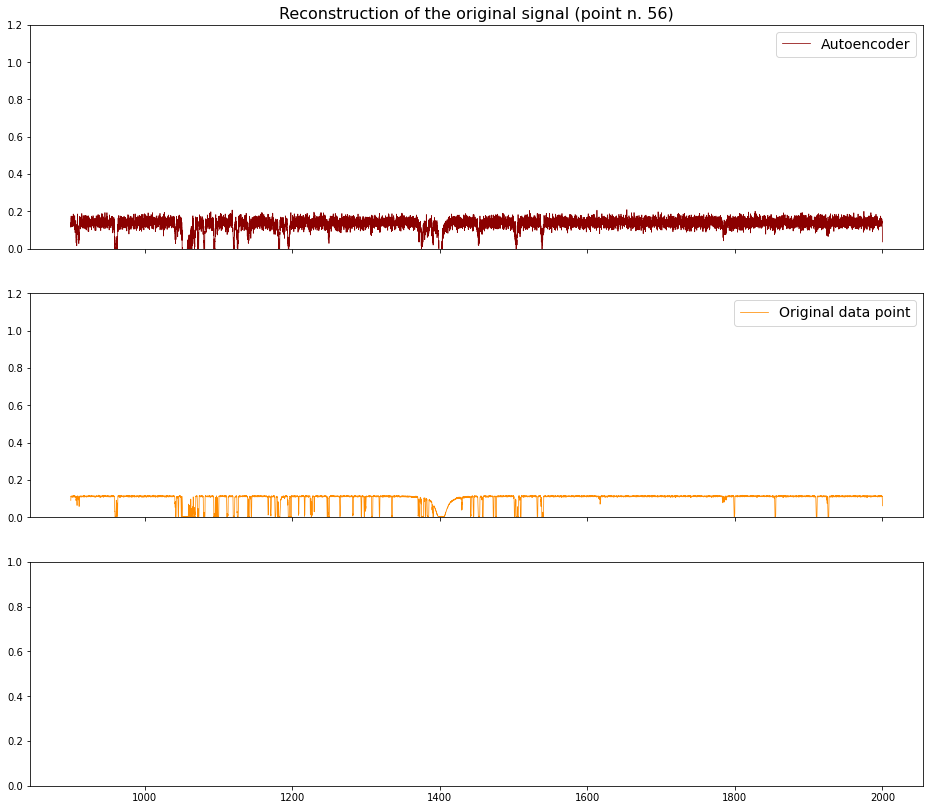

In [32]:
# for random_number in random_number_list:
#     x = tf.expand_dims(x_val[random_number, :], 1)
#     x_projected = autoencoder.predict(x)
#     x_projected_rescaled = rescale_back(x_projected, data_dict["parameters"]["mean"], data_dict["parameters"]["std"],
#                                         data_dict['x_pooled']["val_df_pooled_total_flux"]) 
# #     x_projected_rescaled = x_projected_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"] # [random_number, :]
    
#     x_true_rescaled = rescale_back(x, data_dict["parameters"]["mean"], data_dict["parameters"]["std"],
#                                    data_dict['x_pooled']["val_df_pooled_total_flux"]) 
# #     x_true_rescaled = x_true_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"] # [random_number, :]
#     print(x_true_rescaled.shape)
#     fig, ax = plt.subplots(3, 1, sharex = True, figsize = (16, 14))
#     ax[0].plot(data_dict["wavelengths"], x_projected_rescaled[0][0], label = "Autoencoder", linewidth = 0.75, color = "darkred")
#     ax[0].legend(fontsize = 14)
#     ax[0].set_ylim([0,1.2])
    
#     ax[1].plot(data_dict["wavelengths"], x_true_rescaled[0][0], label = "Original data point", linewidth = 0.75, color = "darkorange")
#     ax[1].legend(fontsize = 14)
#     ax[1].set_ylim([0,1.2])
    
#     ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number) + ")",
#                    fontsize = (16));

In [54]:
mean = data_dict["parameters"]["mean"]
std =  data_dict["parameters"]["std"]
x_val_rescaled = rescale_back(x_val.numpy()[:,0,:], mean, std)
x_val_rescaled_flux = x_val_rescaled * data_dict["x_pooled"]["val_df_pooled_total_flux"]

In [58]:
data_dict["x_pooled"]['val']

,0,1,2,3,4,5,6,7,8,9,...,10991,10992,10993,10994,10995,10996,10997,10998,10999,11000
0,-0.839939,-0.742177,-1.100548,-1.666110,-0.200312,-1.702430,-1.282263,-0.595221,-0.483897,-0.027847,...,-1.039196,0.771327,0.192711,-0.636678,-1.439313,-0.205930,-0.385036,0.729383,-0.919338,0.432550
1,-1.142143,-0.925534,0.422949,-0.530772,-1.275997,-1.103106,-0.191830,-1.186078,-0.597019,-0.014111,...,-1.165823,-1.154442,0.223307,-1.421875,0.709919,-1.316766,-0.639970,-1.452479,-0.592697,0.825160
2,-0.141286,-0.318175,-0.782027,-0.790220,-0.388997,-0.970461,-0.322534,0.223397,-0.167552,-1.447966,...,-1.754763,-2.235737,-1.324259,-1.313493,-0.497929,-1.591131,-0.082456,-0.580248,0.413514,0.803578
3,0.331743,0.236598,0.364454,0.998440,0.322728,0.542714,0.016981,1.309046,0.514389,0.156410,...,1.196476,0.024161,0.733919,-0.440399,-1.704212,-0.580387,0.399553,0.840782,-0.171107,0.316734
4,-0.242389,-1.383048,0.164155,-0.817858,-1.535097,1.312224,-0.217351,0.038473,0.240787,-0.565100,...,-0.552908,0.368396,0.223186,-1.616415,-0.312260,-0.736637,-0.158833,-1.490030,-0.313452,-0.226275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,1.208790,-0.814134,-0.871812,-0.979517,-1.549504,-1.173828,0.266282,-0.747018,-0.226341,-0.781036,...,-0.807191,0.884090,-1.116409,-0.954695,-0.481752,0.286662,-0.318903,-0.536329,0.026434,-1.093501
426,-0.182433,-0.679827,-0.345697,-0.026202,-1.563586,-0.689373,-0.039257,-1.190997,-0.934217,-0.719256,...,0.175036,-0.415901,-1.492979,-0.170424,0.046732,-0.822976,-1.258934,-1.217066,1.797462,-0.380288
427,-0.638989,-1.524191,-0.303773,0.461496,-0.121192,-0.217637,-0.273865,-0.376454,0.149697,-0.005685,...,-1.375227,-0.679333,0.075697,-0.110406,-0.973209,1.874033,0.406269,-0.134460,-0.496694,0.237290
428,-0.194666,0.667123,0.570398,0.105297,0.968624,0.579884,-0.123685,1.364224,0.291685,-0.253771,...,2.413124,-0.362340,0.964682,-1.068894,0.573936,1.687617,-0.751514,-0.036536,1.038552,-1.182220
